# DETR 系列算法: 从原型到SOTA
**原理 · 实验 · 实战**  
AI Tech Sharing · 2025-05-29  
<div style="text-align:right;font-size:32px">Speaker: Rookie</div>

---

## 议程
1. 背景与动机  
2. 原始 DETR  
3. 瓶颈分析 
4. 改进方向
4. Deformable DETR  
5. 轻量级 / 快速变体  
6. SOTA 算法与基准测试  
7. 可视化与演示  
8. 技巧与未来工作

<img src="./imgs/DETR.png.png" style="width:100%;border:none"/>

## 1 · 背景与动机  
<small>Why another detector?</small>  

### 1.1 经典目标检测两条路线  
<br/><br/>
| Two-Stage | One-Stage |  
|-----------|-----------|  
| **Faster R-CNN** <br/>· RPN 产生候选框 <br/>· RoIAlign → 分类/回归 | **YOLO / SSD** <br/>· 直接在特征图上回归类别 + 坐标 |  
| 优：精度高，易插拔 | 优：速度快，端到端训练 | 

#### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;共通流程  
<div style="display:flex;gap:24px">  
  <ul style="font-size:95%; padding-left:800px">  
    <li>CNN 提取特征</li>  
    <li><b>Anchor</b>：预定义框网格</li>  
    <li>分类 + 回归两头训练</li>  
    <li>推理时靠 <b>NMS</b> 去重</li>  
  </ul>  
</div>  


### 1.2 传统方法的痛点  

* 需要大量 **Anchor / IoU / NMS** 超参  
* 多阶段或多任务损失，**端到端不可微**  
* CNN 局部感受野 → **遮挡、长距依赖** 处理差  
* 代码与推理路径复杂，迁移到新领域要 **重新调参**  


#### 超参数依赖性问题
传统检测框架普遍依赖大量人工设定的超参数，包括Anchor尺度与比例、IoU阈值以及NMS抑制参数等。这种高度参数化的设计不仅增加了模型调优的复杂度，更重要的是限制了模型的泛化能力和自适应性。参数敏感性使得模型在面对不同数据分布时需要重新进行繁琐的超参数搜索。

#### 端到端优化障碍
多阶段检测流程和多任务损失函数的设计虽然在一定程度上提升了检测精度，但破坏了端到端训练的连续性。非可微分的后处理步骤阻断了梯度的有效传播，导致整体优化过程次优，无法实现全局最优解。

#### 空间建模局限性
卷积神经网络的局部感受野特性在处理目标遮挡和长距离空间依赖关系时表现不佳。这种局限性在复杂场景中尤为突出，影响了模型对全局上下文信息的有效利用和目标间关系的准确建模。

### 1.3 DETR 的颠覆性思路  
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr_pipline.png" style="width:100%; display:block;">  
    </div>  
    
<div style="flex:0 0 65%;">  
        <ul style="font-size:95%; margin:0; padding-left:500px; padding-top:200px">  
            <li><b>Set Prediction</b>：把检测视作「图片 → 对象集合」</li>  
            <li><b>Transformer</b> 全局自注意力，消除局部瓶颈</li>  
            <li>二分图匹配(匈牙利匹配算法) → 天然去掉 NMS</li>  
            <li>固定长度 Query → 无需 Anchor</li>  
            <li>单损失端到端，简化训练与部署</li>  
        </ul>  
    </div>  
</div>  

## 2 · 原始 DETR
- **架构**：Backbone → Transformer Encoder/Decoder → FFN  
- **对象查询 (Object Queries)**  
- **集合损失 & 匈牙利匹配**  

![](./imgs/DETR.png.png)


### CNN Backbone

#### 架构概述
原始DETR采用在ImageNet上预训练的ResNet作为特征提取骨干网络。经过backbone处理后，输入图像的特征表示发生如下变化：
- **输出通道数**：增至2048维
- **空间分辨率**：降采样至原始尺寸的1/32

#### 设计考量
选择CNN作为backbone的设计考量主要基于以下两个关键因素：
1. 特征层次性匹配: 早期的低级视觉特征（如边缘、纹理等）通常具有较强的局部性特点，长程空间依赖关系相对较弱。CNN的局部感受野和层次化特征提取机制能够高效捕捉这类特征模式。
2. 计算效率优势：相比于完全基于Transformer编码器的纯视觉检测器，CNN backbone在处理低级特征时具有更高的计算效率，能够在保证特征质量的同时显著降低整体模型的计算复杂度。


### Transformer Encoder
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-encode.png" style="width:100%; display:block;">  
    </div>  
 <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>特征预处理</h4>
            <ul>
                <li><strong>降维操作</strong>：由于ResNet输出的通道数 $C=2048$ 维度较高，首先通过 $1 \times 1$ 卷积将特征维度降至256或512，以减少计算复杂度并提升训练效率</li>
                <li><strong>维度重构</strong>：将特征图从 $C \times H \times W$ reshape为 $HW \times C$ 的序列格式</li>
            </ul>
        </div>
</div>


<div style="display: flex; width: 100%;">
    <img src="./imgs/encode-code01.png" style="width: 50%; height: 400px; object-fit: contain;">
    <img src="./imgs/encode-code02.png" style="width: 50%; height: 400px; object-fit: contain;">
</div>

### Transformer Encoder
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-encode.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>全局关系建模</h4>
            <p>自注意力机制在重构后的特征序列上执行全局分析，这一设计具有以下优势：</p>
            <ul>
                <li><strong>大目标优势</strong>：最后一层特征图的感受野较大，对大物体检测友好</li>
                <li><strong>语义关联学习</strong>：Self-Attention能够捕捉不同空间位置间的长程依赖关系，学习对象间的共现模式（如桌子与杯子、草坪与树木的空间关联）</li>
                <li><strong>性能提升</strong>：这正是DETR在大目标检测上优于Faster R-CNN的核心原因</li>
            </ul>
        </div>
    </div>
</div>

### Transformer Encoder
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-encode.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>位置编码机制</h4>
            <ul>
                <li><strong>注入策略</strong>：位置编码在每个Multi-Head Self-Attention层前都会被加入，确保位置信息在整个编码过程中得到充分利用</li>
                <li><strong>2D编码设计</strong>：针对图像的二维特性，分别计算x和y维度的正弦/余弦位置编码，然后拼接形成最终的位置表示</li>
            </ul>
        </div>
    </div>
</div>

<div style="display: flex; width: 90%;">
    <img src="./imgs/encode-code03.png" style="width: 50%; height: 400px; object-fit: contain;">
    <img src="./imgs/encode-code04.png" style="width: 50%; height: 400px; object-fit: contain;">
</div>

### Transformer Decoder
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-decode.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>位置编码与并行解码</h4>
            <ul>
                <li><strong>Object Query设计</strong>：与ViT不同，DETR的Decoder引入位置编码作为可学习的Object Query，使不同查询对应图像中不同位置，实现空间感知的目标检测</li>
                <li><strong>编码注入策略</strong>：位置编码同时添加到Encoder的key和Decoder每一层的query中，确保位置信息在整个解码过程中得到充分利用</li>
                <li><strong>并行解码机制</strong>：摒弃自回归模式，采用并行解码N个对象，通过自注意力和编码器-解码器注意力实现全局推理，平衡计算成本与检测性能</li>
                <li><strong>深监督学习</strong>：每个Decoder层的输出都通过参数共享的FFN进行预测并计算loss，实现多层级监督训练</li>
            </ul>
        </div>
    </div>
</div>

### Prediction Feed-forward Networks
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-head.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>预测网络设计</h4>
            <ul>
                <li><strong>网络结构</strong>：采用3层感知机，配备ReLU激活函数，隐藏维度为d，通过线性投影层输出最终预测结果</li>
                <li><strong>边界框预测</strong>：FFN预测相对于输入图像的归一化边界框坐标（中心点、高度、宽度），确保预测结果的尺度不变性</li>
                <li><strong>类别预测</strong>：线性层通过softmax函数预测类别标签，引入特殊的"∅"类别标识未检测到对象的位置，类似传统方法中的"背景"类别</li>
                <li><strong>固定输出</strong>：由于预测固定的N个边界框（N通常远大于实际目标数量），"∅"类别有效处理空预测槽位</li>
            </ul>
        </div>
    </div>
</div>

### 集合损失  
$$\underset{\sigma \in \mathfrak{S}_N}{\arg\min}\;\sum_{i=1}^{N} \bigl[\lambda_{cls}\,\ell_{CE}(p_{\sigma(i)}, y_i) + \lambda_{box}\,\lVert b_{\sigma(i)} - \hat{b}_i\rVert_1 + \lambda_{iou}(1-\text{IoU}(b_{\sigma(i)}, \hat{b}_i)) \bigr]$$  
匈牙利算法求解 $\sigma$。

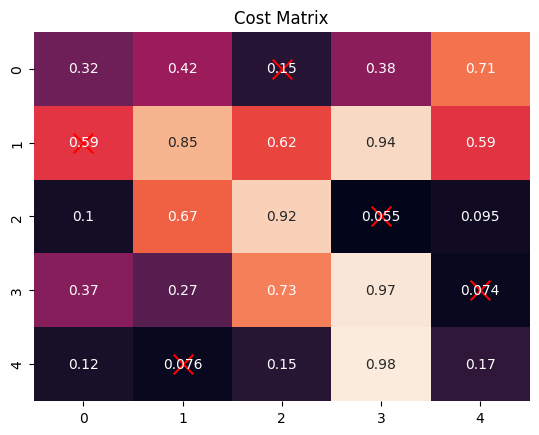

Optimal assignment cost: 0.9387948603306598


In [11]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
cost = np.random.rand(5,5)
row, col = linear_sum_assignment(cost)
sns.heatmap(cost, annot=True, cbar=False)
plt.title("Cost Matrix");plt.scatter(col+.5, row+.5, marker="x", s=200, c="red");plt.show()
print("Optimal assignment cost:", cost[row, col].sum())

## 3 · 瓶颈分析

### 3.1 收敛速度问题
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-head.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>根本原因分析</h4>
            <ul>
                <li><strong>二分图匹配不稳定性</strong>：Hungarian匹配算法在训练初期存在极大不稳定性，预测与真值的匹配关系混乱，导致梯度传播不一致，学习过程缓慢</li>
                <li><strong>Object Query缺乏先验</strong>：目标查询初始状态缺乏空间位置先验，查询间分工不明确，需要从零学习如何关联图像中的具体目标，造成训练低效</li>
            </ul>
        </div>
    </div>
</div>

### 3.2 小目标检测缺陷
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/detr-encode.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>信息稀释机制</h4>
            <ul>
                <li><strong>全局注意力稀释</strong>：小目标在整个特征图中占比极小，Self-Attention计算中其query与大量背景位置产生弱相关，注意力权重被稀释分散，难以获得足够的特征表示</li>
                <li><strong>单尺度限制</strong>：仅使用C5特征图缺乏多尺度信息融合能力，O(N²)的注意力复杂度限制了高分辨率特征的利用，进一步削弱了小目标的检测性能</li>
            </ul>
        </div>
    </div>
</div>

### 3.3 位置编码局限性
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;"> <div style="flex:0 0 30%;"> <img src="./imgs/detr-encode.png" style="width:100%; display:block;"> </div> <div class="container"> <div class="content-block" style="flex:0 0 65%;"> <h4>编码设计缺陷</h4> <ul> <li><strong>绝对编码局限</strong>：使用绝对位置编码，与具体图像尺寸强耦合，难以适应不同分辨率输入</li> <li><strong>空间先验缺失</strong>：Object Query通过随机初始化建模空间信息，与边界框的关联较弱</li> <li><strong>泛化能力差</strong>：训练时的位置编码模式难以迁移到不同尺寸和宽高比的测试图像</li> <li><strong>相对关系缺失</strong>：缺乏相对位置建模能力，限制了空间关系的学习效果</li> </ul> </div> </div> </div>

### 3.4 总结

<div style="text-align: center; margin: 20px 0;">
    <img src="./imgs/detr-html.png.png" style="width: 60%; max-width: 600px; display: block; margin: 0 auto;">
</div>

<div class="container" style="margin-top: 20px;">
    <div class="content-block">
        <h4>瓶颈影响分析</h4>
        <ul>
            <li><strong>训练效率低下</strong>：500 epochs的训练周期大幅增加了计算成本和时间开销</li>
            <li><strong>检测性能受限</strong>：小目标漏检严重影响整体mAP表现，特别是在密集场景中</li>
            <li><strong>实用性不足</strong>：位置编码的泛化问题限制了模型在实际应用中的适应性</li>
        </ul>
    </div>
</div>

## 4. 改进方向

### 4.1 稀疏注意力机制
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/deformable-attn.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4><a href="../paper/Object-Detection/DETR/DEFORMABLE DETR-dual.pdf" target="_blank">Deformable DETR</a></h4>
            <ul>
                <li><strong>多尺度可变形注意力</strong>：摒弃全局密集注意力，仅在每个特征尺度上采样K个关键参考点进行特征聚合，显著降低计算复杂度</li>
                <li><strong>复杂度优化</strong>：将原始DETR的O(N²C²)复杂度降至O(2NqC²+min(HWC², NqKC²))，实现10倍训练周期减少和1.6倍推理加速</li>
                <li><strong>多尺度融合</strong>：无需FPN即可轻松扩展至多尺度特征融合，有效缓解小目标检测问题</li>
                <li><strong>迭代优化</strong>：引入迭代边界框优化策略和两阶段预测方案，进一步提升检测精度，特别是对小物体的检测效果</li>
            </ul>
        </div>
    </div>
</div>

### 4.2 空间先验注入
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/conditional-detr01.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>先验知识融入</h4>
            <ul>
                <li><strong>条件空间查询</strong>：<a href="./paper/Conditional DETR for Fast Training Convergence-dual.pdf" target="_blank">Conditional DETR</a>从参考点映射空间先验，利用条件空间查询机制加速训练收敛</li>
                <li><strong>动态锚框查询</strong>：<a href="../paper/Object-Detection/DETR/" target="_blank">DAB-DETR</a>将Object Query扩展至四维锚框表示，直接将边界框坐标作为查询输入，显著改善训练稳定性</li>
            </ul>
        </div>
    </div>
</div>

### 4.3 结构重设计
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/pix2seq.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>架构创新探索</h4>
            <ul>
                <li><strong>纯编码器方案</strong>：<a href="../paper/Object-Detection/DETR/TSP.pdf" target="_blank">TSP</a>摒弃解码器和Object Query机制，直接规避解码器问题</li>
                <li><strong>自回归编码器</strong>：<a href="https://arxiv.org/abs/2109.10852" target="_blank">Pix2seq</a>将目标检测视为语言建模任务，以自回归方式生成目标描述序列（类别标签和边界框）</li>
                <li><strong>统一架构</strong>：<a href="https://arxiv.org/abs/2106.00666" target="_blank">YOLOS</a>结合ViT结构，用检测标记替代类别标记，统一分类与检测任务</li>
            </ul>
        </div>
    </div>
</div>

### 4.4 匹配优化策略
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/DINO.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>匹配机制改进</h4>
            <ul>
                <li><strong>理论基础</strong>：一对一匹配中的分类成本是避免重复预测的关键要素</li>
                <li><strong>去噪训练</strong>：<a href="../paper/Object-Detection/DETR/DN-DETR-dual.pdf" target="_blank">DN-DETR</a>通过轻微扰动的物体序列重建缓解匹配不稳定性</li>
                <li><strong>对比学习</strong>：<a href="../paper/Object-Detection/DETR/DINO DETR with Improved DeNoising Anchor Boxes for End-to-End Object Detection.pdf" target="_blank">DINO</a>引入对比损失，为距离扰动足够远的负样本附加"无目标"类别</li>
                <li><strong>性能突破</strong>：DINO在COCO数据集上取得当前最优性能，证明匹配优化的有效性</li>
            </ul>
        </div>
    </div>
</div>

### 4.5 自监督预训练
<div style="display:flex; align-items:center; justify-content:space-between; width:100%; margin:20px 0;">  
    <div style="flex:0 0 30%;">  
        <img src="./imgs/DINOv1.png" style="width:100%; display:block;">  
    </div>  
    <div class="container">
        <div class="content-block" style="flex:0 0 65%;">  
            <h4>自监督预训练策略</h4>
            <ul>
                <li><strong>无监督预训练</strong>：<a href="../paper/Object-Detection/DETR/UP-DETR Unsupervised Pre-training for Object Detection with Transformers.pdf" target="_blank">UP-DETR</a>通过图块定位任务进行自监督预训练，利用随机裁剪图块的位置预测任务为目标检测提供有效的初始化权重</li>
                <li><strong>DINOv2预训练</strong>：<a href="../paper/Object-Detection/DETR/RF-DETR Towards Reciprocal Fairness for Object Detection Transformer.pdf" target="_blank">RF-DETR</a>基于<a href="../paper/Object-Detection/DETR/DINOv2 Learning Robust Visual Features without Supervision.pdf" target="_blank">DINOv2</a>自监督预训练模型构建，通过互惠公平性原理和感受野增强机制，在COCO数据集上达到当前SOTA性能水准</li>
            </ul>
        </div>
    </div>
</div>

4.6 总结

<div style="margin:20px 0;">
    <div style="text-align:center; margin-bottom:20px;">
        <img src="./imgs/detr-html.png.png" style="width:60%; display:block; margin:0 auto;">
    </div>
    <div style="width:100%;">
        <h4 style="margin-bottom:15px;">五大改进方向</h4>
        <ul style="padding-left:20px; line-height:1.6;">
            <li style="margin-bottom:8px;"><strong>稀疏注意力机制</strong>：通过可变形注意力降低计算复杂度，实现高效特征聚合</li>
            <li style="margin-bottom:8px;"><strong>空间先验注入</strong>：引入条件查询和动态锚框，加速训练收敛并提升检测精度</li>
            <li style="margin-bottom:8px;"><strong>结构重设计</strong>：探索纯编码器、自回归编码器等新架构，简化模型复杂度</li>
            <li style="margin-bottom:8px;"><strong>匹配优化策略</strong>：通过去噪训练和对比学习改善匹配稳定性，突破性能瓶颈</li>
            <li style="margin-bottom:8px;"><strong>自监督预训练</strong>：利用大规模无标注数据预训练，增强模型泛化能力和特征表示</li>
        </ul>
    </div>
</div>

## 4 · Deformable DETR
- **多尺度 Feature Pyramid**  
- **$K$ 个采样点 (可学习偏移)**  
- 训练 50 epochs 即可收敛  

<video controls width="100%">
  <source src="vids/deform_attn.mp4" type="video/mp4">
</video>

In [ ]:
from IPython.display import JSON
ckpt_info = {"model":"Deformable DETR-R50", "mAP":46.2, "Epochs":50, "Params":"40 M"}
JSON(ckpt_info)

## 5 · 轻量级 / 快速变体

| Year | Model | Trick | mAP | Epoch | FPS* |
|------|-------|-------|-----|-------|------|
| 2021 | Conditional DETR | Split Query | 43.3 | 50 | 26 |
| 2021 | DAB-DETR | Dynamic Anchor | 44.9 | 50 | 26 |
| 2022 | DN-DETR  | Denoising      | 45.8 | 50 | 24 |
| 2022 | DINO     | Dual Matching + DN | **49.0** | 36 | 23 |
| 2023 | RT-DETR  | Real-Time Head | 53.4 | – | **190** |

<small>*FPS on A100, batch = 1</small>

In [ ]:
import plotly.express as px, pandas as pd
data = pd.DataFrame({
    "Model": ["Cond","DAB","DN","DINO","RT"],
    "mAP":   [43.3,44.9,45.8,49.0,53.4],
    "FPS":   [26,26,24,23,190] })
fig = px.scatter(data, x="FPS", y="mAP", text="Model",
                 log_x=True, size=[20]*5,
                 title="Speed-Accuracy Trade-off", height=500)
fig.show()

## 6 · SOTA 算法与基准测试

![](imgs/spider_sota.svg)

In [ ]:
import json, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
results = json.load(open('results/coco_summary.json'))
df = pd.DataFrame(results)
sns.barplot(data=df, x="model", y="AP"); plt.xticks(rotation=30)
plt.title("COCO val mAP"); plt.show()

## 7 · 可视化与演示

In [ ]:
import ipywidgets as wd, PIL.Image as Image
from detr_demo import infer_and_plot   # ← 请自行实现 

uploader = wd.FileUpload(accept="image/*")
display(uploader)

def on_upload(change):
    for meta in uploader.value.values():
        img = Image.open(meta['content']).convert("RGB")
        infer_and_plot("checkpoints/dino_r50.pth", img)
uploader.observe(on_upload, names='value')

> **Demo 互动**  
> 1. 上传图片  
> 2. 切换「显示注意力」开关  
> 3. 观察 Query 分配与检测结果

## 8 · 技巧与未来工作

**训练 Tips**  
- `lr_backbone = 1e-5`, 主干冻结 10 epoch  
- AMP + Grad Clip 0.1  
- Large-Scale Jitter 0.1 – 2.0  

**部署**  
- `torch.compile` + TensorRT  
- 动态 batch & 半精度  

**研究方向**  
- Open-Vocabulary DETR  
- 3D DETR / 多模态 Grounding  
- Edge 侧蒸馏 & 稀疏 Attention

# Q & A  
<br><br>
<center><img src="imgs/qa.svg" width="35%"></center>
<br>
<div style="text-align:center;font-size:24px">感谢聆听，欢迎提问</div>